<img src='./images/self-driving-car.jpg'>

<center> <h1> Self Driving Car </h1> </center>

<br/>
<br/>

## Information & Resources

Credits: https://github.com/SullyChen/Autopilot-TensorFlow
Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



Additional Installations:
pip3 install h5py


AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

<br/>
<br/>

In [1]:
from __future__ import division

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import random
import cv2
import math
import numpy as np
import scipy
import scipy.misc
from scipy import pi
from subprocess import call
from datetime import datetime
from itertools import islice
import matplotlib.pyplot as plt 
import tensorflow as tf

## Lets perform some EDA

In [2]:
image_data = []
angle_data = []

# Get number of images
num_images = 0

# Number of images for training
num_train_images = 0

# Number of images for testing
num_test_images = 0

def load_dataset():
    # Read data.txt
    with open("data/data.txt") as fp:
        for line in fp:
            image_data.append("data/" + line.split()[0])

            # the paper by Nvidia uses the inverse of the turning radius,
            # but steering wheel angle is proportional to the inverse of turning radius
            # so the steering wheel angle in radians is used as the output       
            angle_data.append(float(line.split()[1]) * scipy.pi / 180)

def split_dataset(train_split,test_split):
    images_to_train = image_data[:int(len(image_data) * train_split)]    
    angles_to_train = angle_data[:int(len(image_data) * train_split)]

    images_to_test = image_data[-int(len(image_data) * test_split):]
    angles_to_test = angle_data[-int(len(image_data) * test_split):]
    
    return images_to_train,angles_to_train,images_to_test,angles_to_test   
    

In [3]:
# Load dataset
load_dataset()

# Split dataset
images_to_train,angles_to_train,images_to_test,angles_to_test = split_dataset(0.8,0.2)

num_images = len(image_data)
print("Total number of images: ",num_images)

num_train_images = len(images_to_train)
print("Total number of images for training: ",num_train_images)

num_test_images = len(images_to_test)
print("Total number of images for testing: ",num_test_images)

Total number of images:  45406
Total number of images for training:  36324
Total number of images for testing:  9081


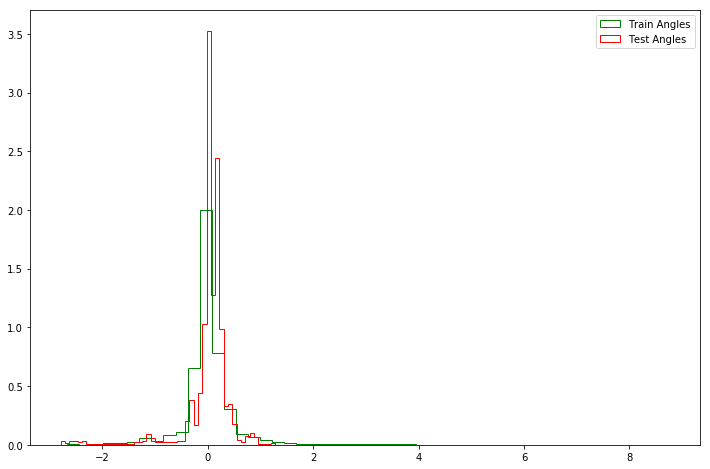

In [4]:
# PDF of train and test angle values. 
plt.figure(figsize=(12,8))
plt.hist(angles_to_train, bins=50, density=1, color='green', histtype ='step',label="Train Angles")
plt.hist(angles_to_test, bins=50, density=1, color='red', histtype ='step',label="Test Angles")
plt.legend()
plt.show()

<br/>
<br/>

By observing above histogram plot, we can apply the simple Base Model

### Model 1: Base line Model: y_test_pred = mean(y_train_i) 

In [5]:
#Model 1: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_angle = np.mean(angles_to_train)

print('Test_MSE(MEAN):%f' % np.mean(np.square(angles_to_test - train_mean_angle)))

Test_MSE(MEAN):0.191142


<br/>
<br/>
<br/>

## Create End to End Model
Credits End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

#### Model 1 - Configuration Used:
Train/Test Split: 80:20 <br/>
Dropout : 0.80 <br/>
AdamOptimezer Value: 1e-4 <br/>
Activation Function: atan

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

In [7]:
true_image = tf.placeholder(tf.float32, shape=[None, 66, 200, 3],name="true_image")
true_angle = tf.placeholder(tf.float32, shape=[None, 1],name="true_angle")

x_image = true_image

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32,name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

# atan activation function with scaling
predicted_angle = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2)
predicted_angle = tf.identity(predicted_angle,name="predicted_angle")

#### Model 2 - Configuration Used:
Train/Test Split: 70:30 <br/>
Dropout : 0.50 <br/>
AdamOptimezer Value: 1e-3 <br/>
Activation Function: linear

In [7]:
true_image_ln = tf.placeholder(tf.float32, shape=[None, 66, 200, 3],name="true_image_ln")
true_angle_ln = tf.placeholder(tf.float32, shape=[None, 1],name="true_angle_ln")

x_image_ln = true_image_ln

#first convolutional layer
W_conv1_ln = weight_variable([5, 5, 3, 24])
b_conv1_ln = bias_variable([24])

h_conv1_ln = tf.nn.relu(conv2d(x_image_ln, W_conv1_ln, 2) + b_conv1_ln)

#second convolutional layer
W_conv2_ln = weight_variable([5, 5, 24, 36])
b_conv2_ln = bias_variable([36])

h_conv2_ln = tf.nn.relu(conv2d(h_conv1_ln, W_conv2_ln, 2) + b_conv2_ln)

#third convolutional layer
W_conv3_ln = weight_variable([5, 5, 36, 48])
b_conv3_ln = bias_variable([48])

h_conv3_ln = tf.nn.relu(conv2d(h_conv2_ln, W_conv3_ln, 2) + b_conv3_ln)

#fourth convolutional layer
W_conv4_ln = weight_variable([3, 3, 48, 64])
b_conv4_ln = bias_variable([64])

h_conv4_ln = tf.nn.relu(conv2d(h_conv3_ln, W_conv4_ln, 1) + b_conv4_ln)

#fifth convolutional layer
W_conv5_ln = weight_variable([3, 3, 64, 64])
b_conv5_ln = bias_variable([64])

h_conv5_ln = tf.nn.relu(conv2d(h_conv4_ln, W_conv5_ln, 1) + b_conv5_ln)

#FCL 1
W_fc1_ln = weight_variable([1152, 1164])
b_fc1_ln = bias_variable([1164])

h_conv5_flat_ln = tf.reshape(h_conv5_ln, [-1, 1152])
h_fc1_ln = tf.nn.relu(tf.matmul(h_conv5_flat_ln, W_fc1_ln) + b_fc1_ln)

keep_prob_ln = tf.placeholder(tf.float32,name="keep_prob_ln")
h_fc1_drop_ln = tf.nn.dropout(h_fc1_ln, keep_prob_ln)

#FCL 2
W_fc2_ln = weight_variable([1164, 100])
b_fc2_ln = bias_variable([100])

h_fc2_ln = tf.nn.relu(tf.matmul(h_fc1_drop_ln, W_fc2_ln) + b_fc2_ln)

h_fc2_drop_ln = tf.nn.dropout(h_fc2_ln, keep_prob_ln)

#FCL 3
W_fc3_ln = weight_variable([100, 50])
b_fc3_ln = bias_variable([50])

h_fc3_ln = tf.nn.relu(tf.matmul(h_fc2_drop_ln, W_fc3_ln) + b_fc3_ln)

h_fc3_drop_ln = tf.nn.dropout(h_fc3_ln, keep_prob_ln)

#FCL 3
W_fc4_ln = weight_variable([50, 10])
b_fc4_ln = bias_variable([10])

h_fc4_ln = tf.nn.relu(tf.matmul(h_fc3_drop_ln, W_fc4_ln) + b_fc4_ln)

h_fc4_drop_ln = tf.nn.dropout(h_fc4_ln, keep_prob_ln)

#Output
W_fc5_ln = weight_variable([10, 1])
b_fc5_ln = bias_variable([1])

# linear activation function
predicted_angle_ln = tf.matmul(h_fc4_drop_ln, W_fc5_ln) + b_fc5_ln
predicted_angle_ln = tf.identity(predicted_angle_ln,name="predicted_angle_ln")

<br/>


## Model Training

### Model 1 with 'atan' activation function

In [8]:
#points to the end of the last batch
train_batch_pointer = 0
test_batch_pointer = 0

# Utility Functions
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(images_to_train[(train_batch_pointer + i) % num_train_images])[-150:], 
                                         [66, 200]) / 255.0)
        y_out.append([angles_to_train[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadTestBatch(batch_size): 
    global test_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(images_to_test[(test_batch_pointer + i) % num_test_images])[-150:], 
                                         [66, 200]) / 255.0)
        y_out.append([angles_to_test[(test_batch_pointer + i) % num_test_images]])
    test_batch_pointer += batch_size
    return x_out, y_out

In [9]:
LOGDIR = './models/atan/'

# Lets start the tensorflow session
sess = tf.InteractiveSession()

In [10]:
start = datetime.now()

print("Let the model learn itself...")
print()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(true_angle, predicted_angle))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)

# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver()

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
previous_i = 0
previous_loss = 0
for epoch in range(epochs):
    for i in range(int(num_images/batch_size)):        
        xs, ys = LoadTrainBatch(batch_size)
        train_step.run(feed_dict={true_image: xs, true_angle: ys, keep_prob: 0.80})
        if i % 10 == 0:            
            xs, ys = LoadTestBatch(batch_size)
            loss_value = loss.eval(feed_dict={true_image:xs, true_angle: ys, keep_prob: 1.0})
            previous_loss = loss_value
            previous_i = i
            # print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

        # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={true_image:xs, true_angle: ys, keep_prob: 1.0})
        summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)            
            checkpoint_path = os.path.join(LOGDIR, "model_atan.ckpt")
            filename = saver.save(sess, checkpoint_path)    
    print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + previous_i, previous_loss)) 
    print("Model saved in file: %s" % filename)
    print()

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

print("\nTime taken to train the model: ",datetime.now() - start)

Let the model learn itself...

Epoch: 0, Step: 450, Loss: 4.36189
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 1, Step: 550, Loss: 3.74218
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 2, Step: 650, Loss: 2.72663
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 3, Step: 750, Loss: 2.4868
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 4, Step: 850, Loss: 2.03206
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 5, Step: 950, Loss: 1.91966
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 6, Step: 1050, Loss: 1.54203
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 7, Step: 1150, Loss: 1.42276
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 8, Step: 1250, Loss: 1.20319
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 9, Step: 1350, Loss: 1.03368
Model saved in file: ./models/atan/model_atan.ckpt

Epoch: 10, Step: 1450, Loss: 0.895972
Model saved in file: ./models/atan/model_atan.ckpt

Epoch:

In [11]:
# Lets close the tensorflow session
sess.close()

### Model 2  with 'linear' activation function

In [9]:
# Split dataset
images_to_train,angles_to_train,images_to_test,angles_to_test = split_dataset(0.7,0.3)

num_images = len(image_data)
print("Total number of images: ",num_images)

num_train_images = len(images_to_train)
print("Total number of images for training: ",num_train_images)

num_test_images = len(images_to_test)
print("Total number of images for testing: ",num_test_images)

# Reset the pointers
train_batch_pointer = 0
test_batch_pointer = 0

Total number of images:  45406
Total number of images for training:  31784
Total number of images for testing:  13621


In [10]:
LOGDIR = './models/linear/'

# Lets start the tensorflow session
sess = tf.InteractiveSession()

In [11]:
start = datetime.now()

print("Let the model learn itself...")
print()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(true_angle_ln, predicted_angle_ln))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)

# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver()

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
previous_i = 0
previous_loss = 0
for epoch in range(epochs):
    for i in range(int(num_images/batch_size)):        
        xs, ys = LoadTrainBatch(batch_size)
        train_step.run(feed_dict={true_image_ln: xs, true_angle_ln: ys, keep_prob_ln: 0.50})
        if i % 10 == 0:            
            xs, ys = LoadTestBatch(batch_size)
            loss_value = loss.eval(feed_dict={true_image_ln:xs, true_angle_ln: ys, keep_prob_ln: 1.0})
            previous_loss = loss_value
            previous_i = i
            # print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

        # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={true_image_ln:xs, true_angle_ln: ys, keep_prob_ln: 1.0})
        summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)            
            checkpoint_path = os.path.join(LOGDIR, "model_linear.ckpt")
            filename = saver.save(sess, checkpoint_path)    
    print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + previous_i, previous_loss)) 
    print("Model saved in file: %s" % filename)
    print()

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

print("\nTime taken to train the model: ",datetime.now() - start)

Let the model learn itself...

Epoch: 0, Step: 450, Loss: 1.94443
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 1, Step: 550, Loss: 0.99808
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 2, Step: 650, Loss: 0.585102
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 3, Step: 750, Loss: 0.930208
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 4, Step: 850, Loss: 0.219191
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 5, Step: 950, Loss: 0.254192
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 6, Step: 1050, Loss: 0.157647
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 7, Step: 1150, Loss: 0.0659127
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 8, Step: 1250, Loss: 0.354662
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 9, Step: 1350, Loss: 0.0425358
Model saved in file: ./models/linear/model_linear.ckpt

Epoch: 10, Step: 1450, Loss: 0.0224573
Model 

In [12]:
# Lets close the tensorflow session
sess.close()

<br/>
<br/>

## Model Testing

Note: 
1. To run model 1, open command prompt or terminal and type 'pyhton3 run_atan.py'
2. To run model 2, open command prompt or terminal and type 'pyhton3 run_linear.py'

<h2> Conclusion </h2>

#### Model 1 peforms descently with almost correct steering angles, whereas Model 2 does not perform well.

#### Creating perfect self driving car model is very hard
#### But still we have managed to develope simple/minimilistic model, which predicts the steering wheel angle.